In [1]:
import os

import pandas as pd
import torch

In [2]:
from dotenv import load_dotenv

# 현재 작업 디렉토리 가져오기
current_dir = os.getcwd()  # 현재 Jupyter Notebook의 작업 디렉토
env_path = os.path.join(current_dir, '../.env')

# .env 파일 로드
load_dotenv(env_path)

True

In [3]:
db_path=os.getenv("DATA_PATH")
ecg_data=pd.read_csv(f'{db_path}/ptbxl_database.csv')
ecg_data.head()

,ecg_id,patient_id,age,sex,height,weight,nurse,site,device,recording_date,...,validated_by_human,baseline_drift,static_noise,burst_noise,electrodes_problems,extra_beats,pacemaker,strat_fold,filename_lr,filename_hr
0,1,15709.0,56.0,1,NaN,63.0,2.0,0.0,CS-12 E,1984-11-09 09:17:34,...,True,NaN,", I-V1,",NaN,NaN,NaN,NaN,3,records100/00000/00001_lr,records500/00000/00001_hr
1,2,13243.0,19.0,0,NaN,70.0,2.0,0.0,CS-12 E,1984-11-14 12:55:37,...,True,NaN,NaN,NaN,NaN,NaN,NaN,2,records100/00000/00002_lr,records500/00000/00002_hr
2,3,20372.0,37.0,1,NaN,69.0,2.0,0.0,CS-12 E,1984-11-15 12:49:10,...,True,NaN,NaN,NaN,NaN,NaN,NaN,5,records100/00000/00003_lr,records500/00000/00003_hr
3,4,17014.0,24.0,0,NaN,82.0,2.0,0.0,CS-12 E,1984-11-15 13:44:57,...,True,", II,III,AVF",NaN,NaN,NaN,NaN,NaN,3,records100/00000/00004_lr,records500/00000/00004_hr
4,5,17448.0,19.0,1,NaN,70.0,2.0,0.0,CS-12 E,1984-11-17 10:43:15,...,True,", III,AVR,AVF",NaN,NaN,NaN,NaN,NaN,4,records100/00000/00005_lr,records500/00000/00005_hr


## 모델 및 하이퍼파라미터 준비
BCResNet의 cnn_first의 stride나 다른 conv의 stride에 따라 입력 또는 출력의 크기가 달라짐.
이는 조절해가면서 실험필요

In [4]:
from ver5_journal.common.BCRnetwork.BCResNets import BCResNets

tau = 1
in_channel = 12
model = BCResNets(int(tau * 8), 5, in_channel)

if in_channel == 1:
    sample = torch.randn(1,12,1000)
else:
    sample = torch.randn(1,12,1000)
    #sample = torch.randn(1,12,20,48)

print(sample.shape)
pred = model(sample)
pred.shape

torch.Size([1, 12, 1000])


[W NNPACK.cpp:64] Could not initialize NNPACK! Reason: Unsupported hardware.


torch.Size([1, 5])

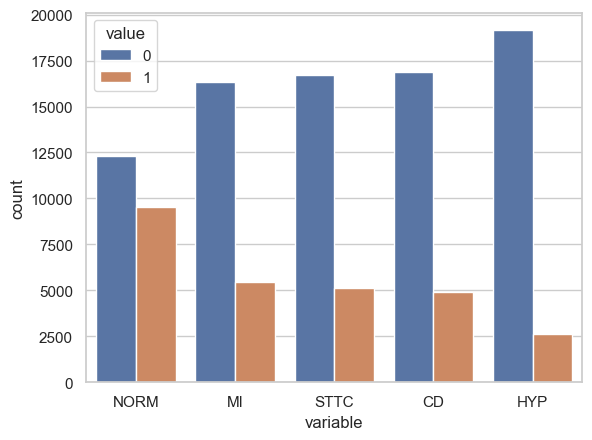

In [5]:
from ver5_journal.common.data.create_final_data import create_final_data
from ver5_journal.common.data.ECG_Data import ECG_Data
from sklearn.metrics import roc_auc_score, accuracy_score
import torch
from torch.utils.data import DataLoader
import numpy as np

# 레이블 순서 : 데이터가 많은 순
label_columns = ['NORM', 'MI', 'STTC', 'CD', 'HYP']
num_epochs = 100

# train/val/test 분리
final_data = create_final_data()
ECG_train = final_data[final_data['strat_fold'].isin([1, 2, 3, 4, 5, 6, 7, 8])].reset_index(drop=True)
ECG_val = final_data[final_data['strat_fold'] == 9].reset_index(drop=True)
ECG_test = final_data[final_data['strat_fold'] == 10].reset_index(drop=True)

# Training 함수 정의
def train_one_epoch(model, train_loader, optimizer, loss_fn, device):
    model.train()
    train_loss = 0
    y_true = []
    y_pred = []

    for data, label in train_loader:
        data, label = data.to(device), label.to(device)
        optimizer.zero_grad()

        output = model(data)
        loss = loss_fn(output.squeeze(-1), label)  # BCEWithLogitsLoss 사용
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

        # Accuracy 계산을 위해 예측값 저장
        y_true.extend(label.cpu().numpy())
        y_pred.extend(output.detach().cpu().numpy())  # Sigmoid 후 확률로 변환

    avg_loss = train_loss / len(train_loader)
    train_accuracy = accuracy_score(np.array(y_true), (np.array(y_pred) > 0.5).astype(int))  # 정확도 계산
    return avg_loss, train_accuracy

# Validation 함수 정의
def validate_one_epoch(model, val_loader, loss_fn, device):
    model.eval()
    val_loss = 0
    y_true = []
    y_pred = []

    with torch.no_grad():
        for data, label in val_loader:
            data, label = data.to(device), label.to(device)

            output = model(data)
            loss = loss_fn(output.squeeze(-1), label)  # BCEWithLogitsLoss 사용
            val_loss += loss.item()
    
            # Accuracy 계산을 위해 예측값 저장
            y_true.extend(label.cpu().numpy())
            y_pred.extend(output.detach().cpu().numpy())  # Sigmoid 후 확률로 변환

    avg_val_loss = val_loss / len(val_loader)
    val_auc = roc_auc_score(y_true, y_pred, average='macro')
    val_accuracy = accuracy_score(np.array(y_true), (np.array(y_pred) > 0.5).astype(int))  # 정확도 계산
    return avg_val_loss, val_auc, val_accuracy

In [6]:
# 데이터 로더 준비
train_dataset = ECG_Data(ECG_train)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

val_dataset = ECG_Data(ECG_val)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=True)

# 모델 정의 및 학습
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

# 모델 정의 및 학습 루프
model = BCResNets(base_c=16, num_classes=5, in_channel=12).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)
loss_fn = torch.nn.BCEWithLogitsLoss()

best_val_auc = float('-inf')  # 가장 높은 AUC를 기록하기 위한 변수
model_path = '../common/one_stage_models.pth'  # 모델 저장 경로

num_epochs = 100
print('Start training...')

for epoch in range(num_epochs):
    # Training 단계
    train_loss, train_accuracy = train_one_epoch(model, train_loader, optimizer, loss_fn, device)
    
    # Validation 단계
    val_loss, val_auc, val_accuracy = validate_one_epoch(model, val_loader, loss_fn, device)
    
    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}')
    print(f'Epoch {epoch+1}/{num_epochs}, Val Loss: {val_loss:.4f}, Val AUC: {val_auc:.4f}, Val Accuracy: {val_accuracy:.4f}')
    
    # AUC가 가장 높을 때 모델을 저장
    if val_auc > best_val_auc:
        best_val_auc = val_auc
        torch.save(model.state_dict(), model_path)  # 모델 저장
        print(f"Best model saved with AUC {best_val_auc:.4f}")

print(f"Training completed. Best AUC: {best_val_auc:.4f}")

Start training...
Epoch 1/100, Train Loss: 0.4484, Train Accuracy: 0.3169
Epoch 1/100, Val Loss: 0.4135, Val AUC: 0.8379, Val Accuracy: 0.3834
Best model saved with AUC 0.8379
Epoch 2/100, Train Loss: 0.3593, Train Accuracy: 0.4475
Epoch 2/100, Val Loss: 0.3976, Val AUC: 0.8499, Val Accuracy: 0.4127
Best model saved with AUC 0.8499
Epoch 3/100, Train Loss: 0.3305, Train Accuracy: 0.5025
Epoch 3/100, Val Loss: 0.3762, Val AUC: 0.8651, Val Accuracy: 0.4132
Best model saved with AUC 0.8651
Epoch 4/100, Train Loss: 0.3197, Train Accuracy: 0.5175
Epoch 4/100, Val Loss: 0.4153, Val AUC: 0.8506, Val Accuracy: 0.2955
Epoch 5/100, Train Loss: 0.3087, Train Accuracy: 0.5321
Epoch 5/100, Val Loss: 0.3854, Val AUC: 0.8670, Val Accuracy: 0.3665
Best model saved with AUC 0.8670
Epoch 6/100, Train Loss: 0.2993, Train Accuracy: 0.5519
Epoch 6/100, Val Loss: 0.3941, Val AUC: 0.8790, Val Accuracy: 0.3733
Best model saved with AUC 0.8790
Epoch 7/100, Train Loss: 0.2944, Train Accuracy: 0.5584
Epoch 7/100